In [86]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import IPython
import pyaudio
import pylab
from scipy.io import wavfile
from IPython.display import Audio
pylab.rcParams['figure.figsize'] = (16, 4)

#### Utilities

In [88]:
def signal(pattern, pulse):
    pulse = np.array(pulse);
    return np.array([ampl * pulse for ampl in pattern]).flatten()

In [89]:
def match_decoder(signal, pulse, dt_sampling, decision):
    match = np.convolve(signal, pulse[::-1])
    samples = match[np.arange(0, len(match), dt_sampling)]
    return [decision(s) for s in samples]

In [90]:
def binarize(text):
    return [int(b) for c in text for b in "{0:08b}".format(ord(c))]

In [91]:
def textarize(binary):
    bin_str = [str(b) for b in binary]
    bin_chunks = ["".join(bin_str[c:c+8]) for c in range(0, len(bin_str), 8)]
    return "".join([chr(int(c, 2)) for c in bin_chunks])

In [92]:
def record(sec, rate):
    ex_chunk = 1024
    ex_format = pyaudio.paInt32
    ex_channel = 2

    p = pyaudio.PyAudio()
    stream = p.open(format=ex_format, channels=ex_channel, rate=rate, input=True, frames_per_buffer=ex_chunk)
    buf = []

    for i in range(0, int(rate / ex_chunk * sec)):
        data = stream.read(ex_chunk)
        buf.append(np.fromstring(data, 'Int32'))

    stream.stop_stream()
    stream.close()
    p.terminate()

    ex_chan = np.array(buf).flatten()
    ex_group = np.reshape(ex_chan, [len(ex_chan) / ex_channel, ex_channel])
    ex = [np.average(g) for g in ex_group]
    assert len(ex) == len(ex_chan) / ex_channel
    
    return ex

In [93]:
def lcs(t1, t2):
    s1 = "".join([str(c) for c in t1])
    s2 = "".join([str(c) for c in t2])
    m = [[0] * (1 + len(s2)) for i in range(1 + len(s1))]
    longest, x_longest = 0, 0
    for x in range(1, 1 + len(s1)):
        for y in range(1, 1 + len(s2)):
            if s1[x - 1] == s2[y - 1]:
                m[x][y] = m[x - 1][y - 1] + 1
                if m[x][y] > longest:
                    longest = m[x][y]
                    x_longest = x
            else:
                m[x][y] = 0
    return s1[x_longest - longest: x_longest]

#### Shared parameters

In [94]:
rate = 8192

dt_sampling = 100
pulse = np.sinc(np.linspace(-dt_sampling/2, dt_sampling/2, dt_sampling))

delim = np.zeros(80) # alternating -1/1
delim[0::2] = 1
delim[1::2] = -1

#### Emitter

In [95]:
d = "The mediocre teacher tells. The good teacher explains. The superior teacher demonstrates. The great teacher gives reading assignments :-)"
d_bin = binarize(d)
d_code = [1 if x == 0 else -1 for x in d_bin]
assert d == textarize(d_bin)
len(d)

137

In [114]:
dt_origin = rate

s_delay = np.zeros(dt_origin)
s_delim = signal(delim, pulse)
s_data = signal(d_code, pulse)

s = np.concatenate((s_delay, s_delim, s_data, s_delim, s_delay))

In [115]:
Audio(s, rate=rate)

In [116]:
sn = s

#### Channel

In [104]:
c_rate, c = wavfile.read("interference.wav")
assert rate == c_rate
Audio(c, rate=rate)

#### Record

In [100]:
recorded = record(18, rate)
Audio(recorded, rate=rate)

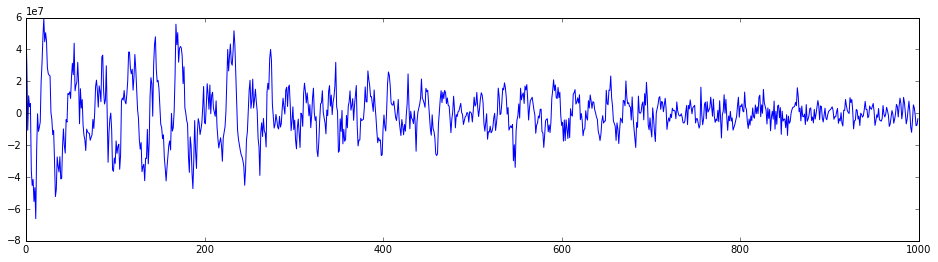

In [101]:
plt.plot(recorded[3000:4000])
plt.show()

In [60]:
sn = recorded

#### Receiver

In [128]:
xcorr = np.correlate(sn, s_delim)
mid = len(xcorr) // 2
start = np.argmax(xcorr[:mid])
end = len(xcorr) - np.argmax(np.flipud(xcorr[mid:]))
print(start)
print(end)

8192
125793


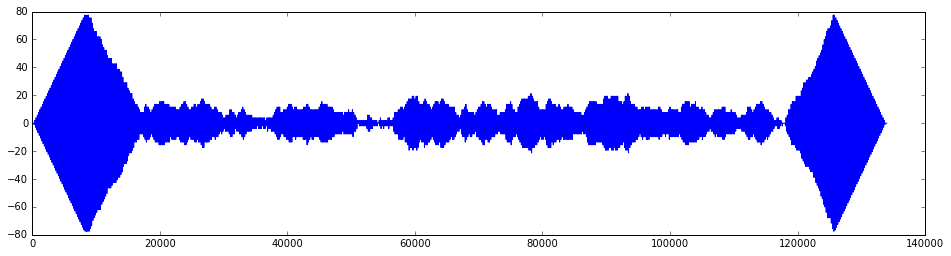

In [135]:
plt.plot(xcorr)

In [131]:
r_delim = sn[start:end]
r_align = match_decoder(r_delim, pulse, dt_sampling, lambda x: 1 if x < 0 else 0)
r = r_align[len(delim)+1:]

<Container object of 3 artists>

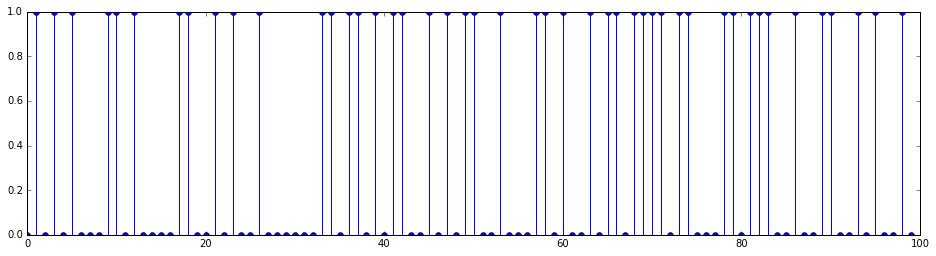

In [137]:
plt.stem(r[0:100])

In [133]:
received = textarize(r)
print(len(r))
received

1096


'The mediocre teacher tells. The good teacher explains. The superior teacher demonstrates. The great teacher gives reading assignments :-)'

In [134]:
print(len(d_bin))
d

1096


'The mediocre teacher tells. The good teacher explains. The superior teacher demonstrates. The great teacher gives reading assignments :-)'

In [84]:
lcs(d_bin, r)


'00110010100100000011011010110010101100100011010010110111101100011011100100110010100100000011101000110010101100001011000110110100001100101011100100010000001110100011001010110110001101100011100110010111000100000010101000110100001100101001000000110011101101111011011'

#### Todos

- amplitude bounds (100Hz - 20KHz)
- mean noise subtraction
- find best amplitude
- lowerpass match
- block with parity checks


In [24]:
ex = s

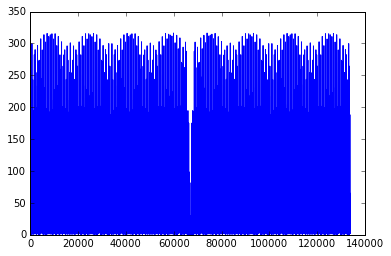

In [25]:
plt.plot(abs(np.fft.fft(ex)))

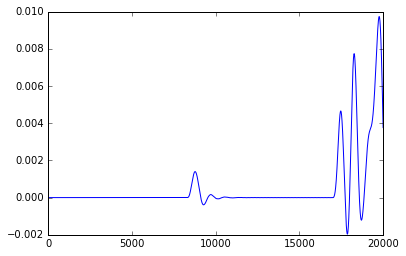

In [26]:
from scipy.signal import butter, lfilter, freqz

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

cutoff = 10
order = 6

b, a = butter_lowpass(cutoff, rate, order)
y = lfilter(b, a, ex)
plt.plot(y[0:20000])

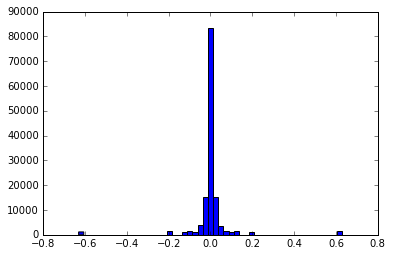

In [27]:
plt.hist(ex, bins=51)

In [28]:
min(ex)

-0.63017424316041637

In [29]:
max(ex)

0.63017424316041637

In [30]:
np.average(ex)

0.00071042884332167674

In [31]:
T = 10
t = np.linspace(0, T, int(T * rate))
s_440 = np.sin(2 * np.pi * 440 * t)
s_261 = np.sin(2 * np.pi * 261.63 * t)

In [32]:
Audio(s_440, rate=rate)

In [33]:
Audio(s_261, rate=rate)

In [34]:
s_mix = s_440 * 1000 + s_261 * 500
Audio(s_mix, rate=rate)

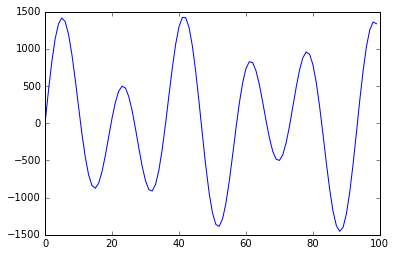

In [35]:
plt.plot(s_mix[:100])